In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
csv_path_launch_ts = "job_launch_ts.csv"
df_launch = pd.read_csv(csv_path_launch_ts).fillna("")
# deduplication by run_name, take the first one
print(df_launch.shape)
df_launch = df_launch.sort_values(by='run_name', ascending=False).drop_duplicates(subset='run_name', keep='first')
print(df_launch.shape)
df_launch.sample(2)

(465, 2)
(347, 2)


,run_name,launch_time
348,time-to-train_1b-llama-tok-us-west4-a-v5litepo...,2024-07-19 08:14:17 PM PDT
413,time-to-train_1b-llama-tok-us-west4-a-v5litepo...,2024-07-20 02:24:58 PM PDT


In [3]:
csv_path_jobs = "wandb_runs_time-to-train.csv"
df_jobs = pd.read_csv(csv_path_jobs)
print(df_jobs.shape)
# rename total_time to total_job_time
df_jobs = df_jobs.rename(columns={"total_time": "total_job_time"})
df_jobs.sample(2)

(145, 13)


,run_name,runtime,total_job_time,training_time,create_time,heartbeat_time,tokenizer,train_batch_size,examples_per_second,global_step,parameters,num_devices,mfu
102,time-to-train_1b-llama-tok-v5litepod-256-16b55...,5.780276,10.505000,3.606465,2024-07-16 00:00:08 PDT,2024-07-16 10:30:26 PDT,meta-llama/Llama-2-7b-hf,1024,757.553149,9605,1204881408,256,NaN
29,time-to-train_1b-llama-tok-us-central2-b-v4-25...,3.241799,19.673889,2.911241,2024-07-20 15:45:57 PDT,2024-07-21 11:26:23 PDT,meta-llama/Llama-2-7b-hf,1024,479.636660,4909,1204881408,128,46.650285


In [4]:
df = pd.merge(df_jobs, df_launch, on="run_name", how="left").fillna("")
print(df.shape)
df.sample(2)

(145, 14)


,run_name,runtime,total_job_time,training_time,create_time,heartbeat_time,tokenizer,train_batch_size,examples_per_second,global_step,parameters,num_devices,mfu,launch_time
40,time-to-train_1b-llama-tok-us-central2-b-v4-25...,15.473418,21.885278,14.623162,2024-07-20 14:31:27 PDT,2024-07-21 12:24:34 PDT,meta-llama/Llama-2-7b-hf,1024,479.696833,24661,1204881408,128,46.689886,2024-07-20 02:24:39 PM PDT
97,time-to-train_1b-llama-tok-v5litepod-256-d4fad...,4.130289,4.152222,3.379512,2024-07-16 22:03:14 PDT,2024-07-17 02:12:22 PDT,meta-llama/Llama-2-7b-hf,1024,757.505903,9000,1204881408,256,,2024-07-16 09:55:48 PM PDT


In [5]:
from dateutil import parser

def get_total_time_from_launch(launch_time_str: str, end_time_str: str) -> float:
    if not launch_time_str or not end_time_str:
        return

    launch_time = parser.parse(launch_time_str)
    end_time = parser.parse(end_time_str)
    diff = end_time - launch_time
    diff_seconds = diff.total_seconds()
    diff_hrs = diff_seconds / 3600.0
    return diff_hrs

df["total_time_from_launch"] = df.apply(lambda row: get_total_time_from_launch(row["launch_time"], row["heartbeat_time"]), axis=1)

/home/shared/miniconda3/envs/ivan/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [15]:
def get_tpu_type(run_name: str) -> str:
    # default value
    tpu_type = "v5lite-256"
    tpu_zone = "us"

    if "v4-256" in run_name or "v4" in run_name:
        tpu_type = "v4-256"
    else:
        tpu_type = "v5lite-256"
    
    if "europe-west4-b" in run_name:
        tpu_zone = "eu"
    else:
        tpu_zone = "us"
    return f"{tpu_type}({tpu_zone})"

df["tpu_type"] = df["run_name"].apply(get_tpu_type)
df["tpu_type"].value_counts()

tpu_type
v4-256(us)        85
v5lite-256(us)    34
v5lite-256(eu)    26
Name: count, dtype: int64

In [16]:
"""
I have a dataframe with the following columns:
- launch_time: the time a job is launched
- create_time: the time when a cluster is allocated for the job
- heartbeat_time: the last time a job is active
- tpu_type: the type of the TPU that the job is using/going to use

I want to create a function that, for each row, calculates that
by the time the job is launched, how many clusters of the same tpu_type
are actively running.

Think thought this problem step-by-step, then write the function
"""
def count_active_clusters(df):
    def parse_date(date_str):
        if not date_str:
            return ""
        if isinstance(date_str, datetime):
            return date_str
        return parser.parse(date_str)

    for col in ['launch_time', 'heartbeat_time', 'create_time']:
        df[col] = df[col].apply(parse_date)

    # Initialize a list to store the counts
    cluster_counts_at_launch, cluster_counts_at_running = [], []

    for _, row in df.iterrows():
        tpu_type = row['tpu_type']
        create_time = row["create_time"]

        # Count active clusters of the same tpu_type at launch_time
        count = sum(
            (df["tpu_type"] == row['tpu_type']) &
            (df["heartbeat_time"] > create_time) & (df["create_time"] < create_time)
        )
        cluster_counts_at_launch.append(count)

        # Count ative clusters between create_time and heartbeat_time
        count = sum(
            (df["tpu_type"] == row['tpu_type']) &
            (df["heartbeat_time"] > create_time) & (df["create_time"] < row["heartbeat_time"])
        )
        cluster_counts_at_running.append(count)

    df['clusters_at_create'] = cluster_counts_at_launch
    df['clusters_at_running'] = cluster_counts_at_running

    return df

# Usage:
# df = pd.read_csv('your_data.csv')  # Load your dataframe
# df_with_counts = count_active_clusters(df)


df = count_active_clusters(df)

In [17]:
import seaborn as sns


def get_time_to_launch(row):
    if "total_time_from_launch" not in row:
        return ""
    return row["total_time_from_launch"] - row["total_job_time"]

df["time_to_create_cluster"] = df.apply(get_time_to_launch, axis=1)

# Get unique TPU types for color assignment
tpu_types = df['tpu_type'].unique()
# colors = plt.cm.plasma(np.linspace(0, 1, len(tpu_types)))
colors = sns.color_palette("husl", len(tpu_types))


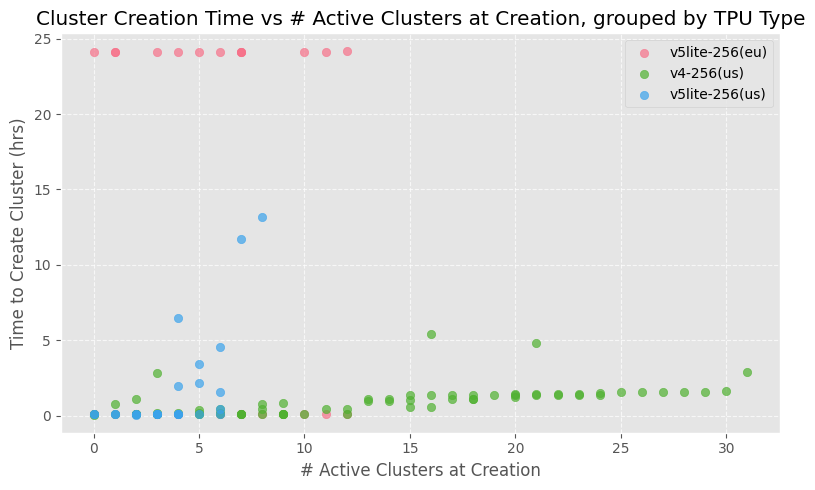

In [18]:
# Create a scatter plot
plt.figure(figsize=(8, 5))

# Plot each TPU type with a different color
for tpu_type, color in zip(tpu_types, colors):
    mask = df['tpu_type'] == tpu_type
    plt.scatter(df.loc[mask, 'clusters_at_create'],
                df.loc[mask, 'time_to_create_cluster'],
                c=[color],
                label=tpu_type,
                alpha=0.7)

# Set labels and title
plt.xlabel('# Active Clusters at Creation')
plt.ylabel('Time to Create Cluster (hrs)')
plt.title('Cluster Creation Time vs # Active Clusters at Creation, grouped by TPU Type')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

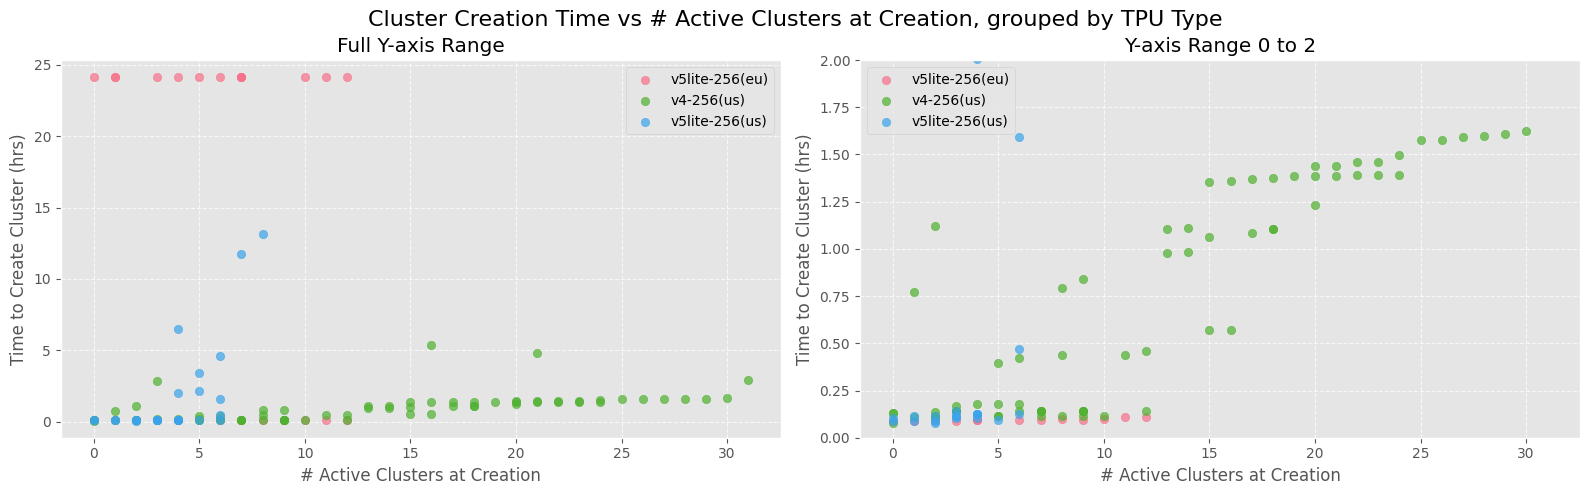

In [25]:
# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Add a main title
fig.suptitle('Cluster Creation Time vs # Active Clusters at Creation, grouped by TPU Type', fontsize=16)

# Function to plot data on a given axis
def plot_data(ax):
    for tpu_type, color in zip(tpu_types, colors):
        mask = df['tpu_type'] == tpu_type
        ax.scatter(df.loc[mask, 'clusters_at_create'],
                   df.loc[mask, 'time_to_create_cluster'],
                   c=[color],
                   label=tpu_type,
                   alpha=0.7)
    
    ax.set_xlabel('# Active Clusters at Creation')
    ax.set_ylabel('Time to Create Cluster (hrs)')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.legend()

# Plot on the first subplot (full range)
plot_data(ax1)
ax1.set_title('Full Y-axis Range')

# Plot on the second subplot (y-axis from 0 to 2)
plot_data(ax2)
ax2.set_ylim(0, 2)
ax2.set_title('Y-axis Range 0 to 2')

# Adjust layout
plt.tight_layout()

# Adjust the layout to make room for the main title
plt.subplots_adjust(top=0.88)

# Show the plot
plt.show()


In [26]:
df["effective_training"] = df["runtime"] / df["total_job_time"]

def get_time_to_1t(row):
    seq_len = 4096
    target = 1000000000000.0
    train_batch_size = row["train_batch_size"]
    global_step = row["global_step"]
    total_job_time = row["total_job_time"]
    total_steps = target / seq_len / train_batch_size
    time_to_train = total_steps / global_step * total_job_time
    return time_to_train


df["time_to_train_1T"] = df.apply(get_time_to_1t, axis=1)

# filter out jobs whose training_time is less than 1 hr
df_filtered = df[df["training_time"] > 1]
len(df), len(df_filtered)

(145, 132)

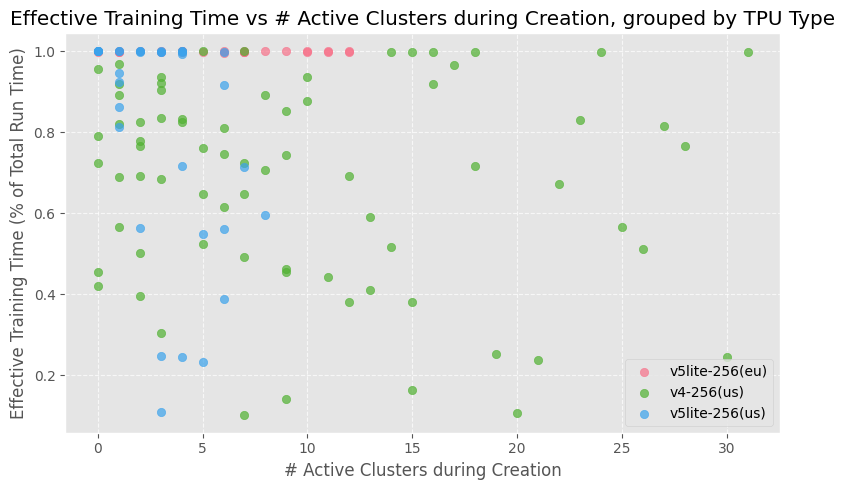

In [27]:
# Create a scatter plot
plt.figure(figsize=(8, 5))

# Plot each TPU type with a different color
for tpu_type, color in zip(tpu_types, colors):
    mask = df_filtered['tpu_type'] == tpu_type
    plt.scatter(df_filtered.loc[mask, 'clusters_at_create'],
                df_filtered.loc[mask, 'effective_training'],
                c=[color],
                label=tpu_type,
                alpha=0.7)

# Set labels and title
plt.xlabel('# Active Clusters during Creation')
plt.ylabel('Effective Training Time (% of Total Run Time)')
plt.title('Effective Training Time vs # Active Clusters during Creation, grouped by TPU Type')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


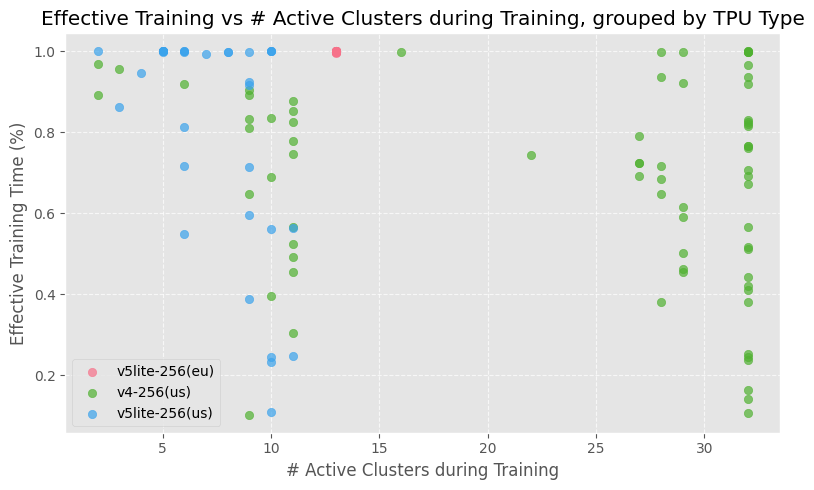

In [28]:
# Create a scatter plot
plt.figure(figsize=(8, 5))

# Plot each TPU type with a different color
for tpu_type, color in zip(tpu_types, colors):
    mask = df_filtered['tpu_type'] == tpu_type
    plt.scatter(df_filtered.loc[mask, 'clusters_at_running'],
                df_filtered.loc[mask, 'effective_training'],
                c=[color],
                label=tpu_type,
                alpha=0.7)

# Set labels and title
plt.xlabel('# Active Clusters during Training')
plt.ylabel('Effective Training Time (%)')
plt.title('Effective Training vs # Active Clusters during Training, grouped by TPU Type')

# Add legend
plt.legend()

# Show grid
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


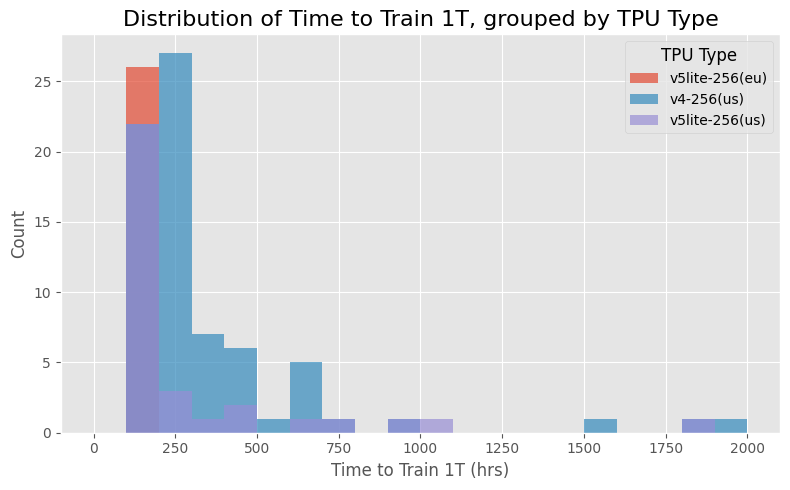

In [29]:
# Assuming you have your data in a DataFrame called 'df'
# If not, you'll need to load your data first
# df = pd.read_csv('your_data.csv')

# Set the style for better-looking plots
plt.style.use('ggplot')

# Get unique TPU types
tpu_types = df_filtered['tpu_type'].unique()

# Create the histogram
plt.figure(figsize=(8, 5))

for tpu_type in tpu_types:
    subset = df_filtered[df_filtered['tpu_type'] == tpu_type]
    plt.hist(subset['time_to_train_1T'], bins=20, range=(0, 2000), alpha=0.7, label=tpu_type)

# Customize the plot
plt.title('Distribution of Time to Train 1T, grouped by TPU Type', fontsize=16)
plt.xlabel('Time to Train 1T (hrs)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add a legend
plt.legend(title='TPU Type', title_fontsize='12', fontsize='10')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

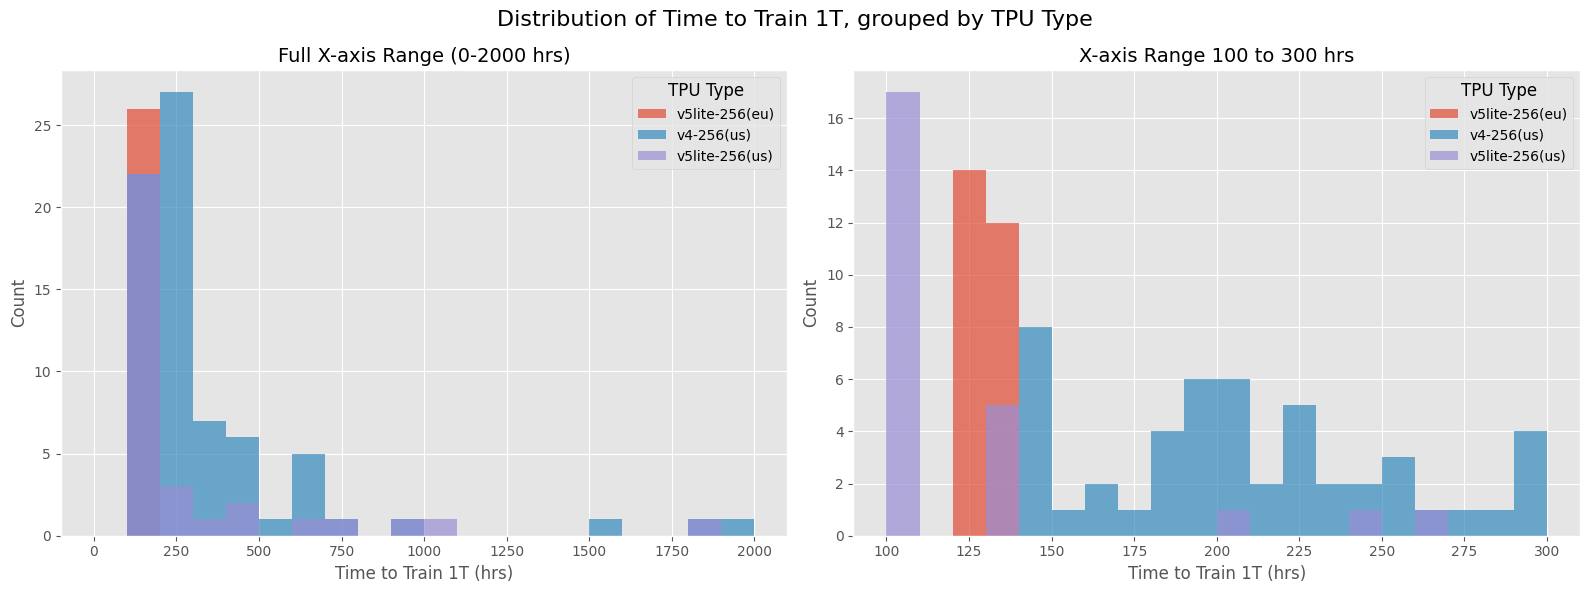

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Set the style for better-looking plots
plt.style.use('ggplot')

# Get unique TPU types
tpu_types = df_filtered['tpu_type'].unique()

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Function to plot histogram on a given axis
def plot_histogram(ax, x_range=None):
    for tpu_type in tpu_types:
        subset = df_filtered[df_filtered['tpu_type'] == tpu_type]
        ax.hist(subset['time_to_train_1T'], bins=20, range=x_range, alpha=0.7, label=tpu_type)
    
    ax.set_xlabel('Time to Train 1T (hrs)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.legend(title='TPU Type', title_fontsize='12', fontsize='10')

# Plot on the first subplot (full range)
plot_histogram(ax1, x_range=(0, 2000))
ax1.set_title('Full X-axis Range (0-2000 hrs)', fontsize=14)

# Plot on the second subplot (x-axis from 0 to 200)
plot_histogram(ax2, x_range=(100, 300))
ax2.set_title('X-axis Range 100 to 300 hrs', fontsize=14)

# Add a main title
fig.suptitle('Distribution of Time to Train 1T, grouped by TPU Type', fontsize=16)

# Adjust the layout manually
plt.tight_layout()
plt.subplots_adjust(top=0.88)  # Make room for the main title

# Show the plot
plt.show()


In [14]:
df.to_csv("wandb_runs_with_launch_ts.csv", index=False)